In [1]:
import sys
from loadCellsFile import *
from utilities import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from scipy.sparse.csgraph import dijkstra
import scipy.io

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, LinearLR
from torch.utils.data import DataLoader
from torch_nl3rSetup import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.decomposition import PCA

from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler

In [2]:
# mat = scipy.io.loadmat("./data/jk013_02012023.RRRmdls_forCarlos.mat", simplify_cells=True)["RRRmdls"]
mat = scipy.io.loadmat("./data/jk013_02012023_100ms.timeSeries.cellinfo_forCarlos.mat", simplify_cells=True)

In [3]:
HPC = mat['HPC'].astype("float")
PFC = mat['PFC'].astype("float")

In [4]:
# find trial boundaries
bounds = np.diff((mat['variables']['taskPhase'] != 4).astype('int'))
bounds[0] = 1

starts = np.argwhere(bounds == 1).flatten()
ends = np.argwhere(bounds == -1).flatten()

In [5]:
# extract trials
train_inds = []

trials_HPC = []
trials_PFC = []
for i in range(starts.shape[0]):
    # add trial
    start = starts[i]
    end = ends[i]

    trials_HPC.append(HPC[start:end,:].astype('float'))
    trials_PFC.append(PFC[start:end,:].astype('float'))
    train_inds.append(np.arange(start, end))


    # add ITI
    if (i+1 < starts.shape[0]):
        iti_start = end
        iti_end = starts[i+1]

        trials_HPC.append(HPC[iti_start:iti_end,:].astype('float'))
        trials_PFC.append(PFC[iti_start:iti_end,:].astype('float'))
        train_inds.append(np.arange(iti_start, iti_end))


trials_HPC = np.array(trials_HPC, dtype="object")
trials_PFC = np.array(trials_PFC, dtype="object")
trial_inds = np.array(train_inds, dtype="object")

In [6]:
for i, trial in enumerate(trials_HPC):
    sigmas = np.maximum(1/(trial.mean(axis=0)/.1), .15)/.1
    sigmas[sigmas == np.inf] = trial.shape[0]

    for j in range(trial.shape[1]):
        trial[:, j] = scipy.ndimage.gaussian_filter1d(trial[:,j], sigmas[j], axis=0)

    trials_HPC[i] = trial

for i, trial in enumerate(trials_PFC):
    sigmas = np.maximum(1/(trial.mean(axis=0)/.1), .15)/.1
    sigmas[sigmas == np.inf] = trial.shape[0]

    for j in range(trial.shape[1]):
        trial[:, j] = scipy.ndimage.gaussian_filter1d(trial[:,j], sigmas[j], axis=0)

    trials_PFC[i] = trial

 C:\Users\Harris_Lab\AppData\Local\Temp\ipykernel_23456\1473042675.py:2: RuntimeWarning:divide by zero encountered in divide
 C:\Users\Harris_Lab\AppData\Local\Temp\ipykernel_23456\1473042675.py:11: RuntimeWarning:divide by zero encountered in divide


In [7]:
# calculate and smooth trial averages

HPC_trial_avg = np.zeros((len(trials_HPC), HPC.shape[1]))

for i, rates in enumerate(trials_HPC):
    HPC_trial_avg[i, :] = rates.mean(axis=0)

PFC_trial_avg = np.zeros((len(trials_PFC), PFC.shape[1]))

for i, rates in enumerate(trials_PFC):
    PFC_trial_avg[i, :] = rates.mean(axis=0)

HPC_trial_avg_smooth = scipy.ndimage.gaussian_filter1d(HPC_trial_avg, 10, axis=0)
PFC_trial_avg_smooth = scipy.ndimage.gaussian_filter1d(PFC_trial_avg, 10, axis=0)

In [8]:
# correct for slow average
trials_HPC_norm = np.zeros_like(trials_HPC, dtype="object")
trials_PFC_norm = np.zeros_like(trials_PFC, dtype="object")

for i in range(len(trials_HPC)):
    trials_HPC_norm[i] = trials_HPC[i] - HPC_trial_avg_smooth[i]
    trials_PFC_norm[i] = trials_PFC[i] - PFC_trial_avg_smooth[i]

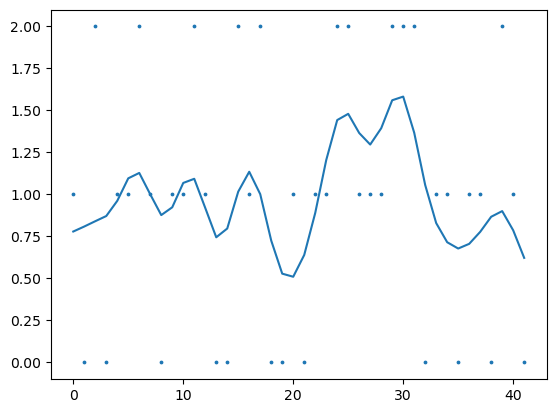

In [9]:
trial = 10
neuron = 50

plt.plot(trials_HPC[trial][:,neuron])
plt.scatter(np.arange(trials_HPC[trial].shape[0]), HPC[trial_inds[trial], neuron], s=3)

In [12]:
# time-stratified train-test split
test_inds = np.arange(0, len(trials_HPC), 8)
train_inds = [ind for ind in np.arange(0, len(trials_HPC)) if (ind not in test_inds)]

HPC_train = np.vstack((trials_HPC_norm[train_inds]))  # type: ignore
HPC_test = np.vstack((trials_HPC_norm[test_inds]))  # type: ignore

PFC_train = np.vstack((trials_PFC_norm[train_inds]))  # type: ignore
PFC_test = np.vstack((trials_PFC_norm[test_inds]))  # type: ignore

var_inds = np.concatenate(trial_inds[train_inds])


In [11]:
A = scipy.io.loadmat('./data/jk013_02012023.RRRmdls_forCarlos.mat', variable_names='RRRmdls')

In [151]:
rank   = A['RRRmdls']['rank'][0,0][0,0]
Nfolds = A['RRRmdls']['Nfolds'][0,0][0,0]
folds  = A['RRRmdls']['fold'][0,0].flatten()

HPC_train = folds[1]['HPC_train'][0,0]
HPC_test  = folds[1]['HPC_test'][0,0]
PFC_train = folds[1]['PFC_train'][0,0]
PFC_test  = folds[1]['PFC_test'][0,0]

In [14]:
nHPC = HPC_train.shape[1]   # number of HPC cells
nPFC = PFC_train.shape[1]   # number of PFC cells
nbins = HPC_train.shape[0]  # number of time bins

In [13]:
HPC_train = torch.Tensor(HPC_train).to(device)
HPC_test = torch.Tensor(HPC_test).to(device)

PFC_train = torch.Tensor(PFC_train).to(device)
PFC_test = torch.Tensor(PFC_test).to(device)

In [25]:
dims = [1,2,3,4,5,7,10,15, 20, 30 , 50, 75, 100, 150]
# dims = [2]
cross_accs = np.ones_like(dims, dtype="float")
cross_accs_test = np.ones_like(dims, dtype="float")
cross_test_vars = np.zeros_like(dims, dtype="float")

for i, dim in enumerate(dims):
    min_test = 999
    print("---------------- DIM = %d ----------------" % dim)
    lr = 0.001

    fullModel = bottleneck(nHPC, nPFC, dim, 10, 200).to(device)
    optimizer = torch.optim.Adam(fullModel.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(fullModel.parameters(), lr=lr, momentum=.9)
    scheduler = LinearLR(optimizer, total_iters = 10000, start_factor=1, end_factor=1/25)
    # scheduler = CosineAnnealingWarmRestarts(optimizer, 200, 2)

    for epoch in range(2001):
        
        out, z = fullModel(HPC_train)
        loss = torch.nn.functional.mse_loss(out, PFC_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        scheduler.step()

        if epoch%100 == 0:
            print("Epoch %d | train loss: %.4f | test loss: %.4f" % 
                (epoch,
                loss.detach().cpu().numpy(),
                torch.nn.functional.mse_loss(fullModel(HPC_test)[0], PFC_test).detach().cpu().numpy()
                )
            )
        min_test = min(min_test, torch.nn.functional.mse_loss(fullModel(HPC_test)[0], PFC_test).detach().cpu().numpy())

        s1 = torch.var(PFC_test, dim=0).mean()
        s2 = torch.var(PFC_test - fullModel(HPC_test)[0], dim=0).mean()
        cross_test_vars[i] = max(cross_test_vars[i], 1-s2/s1)

    cross_accs[i] = loss.detach().cpu().numpy()
    cross_accs_test[i] = min_test

    

---------------- DIM = 1 ----------------
Epoch 0 | train loss: 0.2221 | test loss: 0.2415
Epoch 100 | train loss: 0.1757 | test loss: 0.2059
Epoch 200 | train loss: 0.1628 | test loss: 0.1979
Epoch 300 | train loss: 0.1602 | test loss: 0.1984
Epoch 400 | train loss: 0.1604 | test loss: 0.1952
Epoch 500 | train loss: 0.1609 | test loss: 0.2005
Epoch 600 | train loss: 0.1520 | test loss: 0.1965
Epoch 700 | train loss: 0.1494 | test loss: 0.1948
Epoch 800 | train loss: 0.1625 | test loss: 0.1988
Epoch 900 | train loss: 0.1525 | test loss: 0.1920
Epoch 1000 | train loss: 0.1496 | test loss: 0.1903
Epoch 1100 | train loss: 0.1483 | test loss: 0.1901
Epoch 1200 | train loss: 0.1544 | test loss: 0.1977
Epoch 1300 | train loss: 0.1487 | test loss: 0.1918
Epoch 1400 | train loss: 0.1522 | test loss: 0.1936
Epoch 1500 | train loss: 0.1475 | test loss: 0.1880
Epoch 1600 | train loss: 0.1499 | test loss: 0.1913
Epoch 1700 | train loss: 0.1539 | test loss: 0.1922
Epoch 1800 | train loss: 0.1504 | 

In [177]:
fullModel

bottleneck(
  (encoder): nl3ize(
    (layers): ModuleList(
      (0): Linear(in_features=96, out_features=100, bias=True)
      (1-9): 9 x Linear(in_features=100, out_features=100, bias=True)
      (10): Linear(in_features=100, out_features=1, bias=True)
    )
  )
  (decoder): nl3ize(
    (layers): ModuleList(
      (0): Linear(in_features=1, out_features=100, bias=True)
      (1-9): 9 x Linear(in_features=100, out_features=100, bias=True)
      (10): Linear(in_features=100, out_features=348, bias=True)
    )
  )
)

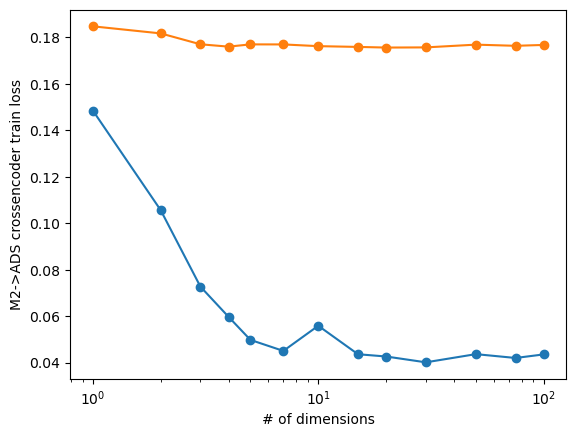

In [203]:
plt.plot(dims[:-1], cross_accs[:-1], marker='o'); plt.ylabel("M2->ADS crossencoder train loss"); plt.xlabel("# of dimensions")
plt.plot(dims[:-1], cross_accs_test[:-1], marker='o'); plt.xscale('log')

In [26]:
# out = model(HPC_test)
out, z = fullModel(HPC_test)

s1 = torch.var(PFC_test, dim=0).mean()
s2 = torch.var(PFC_test - out, dim=0).mean()

# s1 = (torch.linalg.norm(PFC_test)**2).mean()
# s2 = (torch.linalg.norm(PFC_test - mu)**2).mean()
print(1-s2/s1)

tensor(-0.1272, device='cuda:0', grad_fn=<RsubBackward1>)


In [139]:
print(s1)

tensor(0.4541, device='cuda:0')


In [128]:
s1.shape

torch.Size([348])

In [ ]:
torch.R2

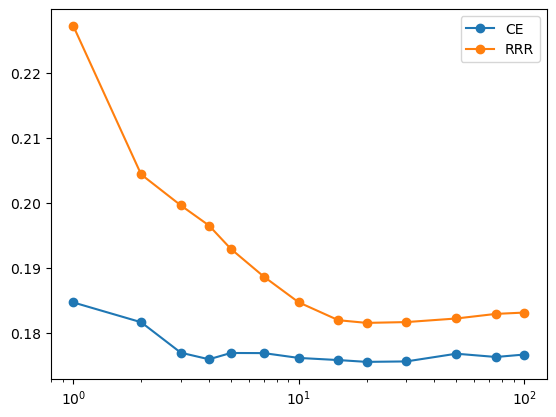

In [205]:
plt.plot(dims[:-1], cross_accs_test[:-1], marker='o', label="CE");
plt.plot(dims[:-1], test_acc[:-1], marker='o', label="RRR");  plt.xscale('log');

plt.legend()

In [18]:
class encoder_lin(nn.Module):
    def __init__(self, nInputs, nOutputs):
        super(encoder_lin, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(nInputs, nOutputs))
        
    def forward(self, x):
        return self.layers[0](x)
    
class decoder_lin(nn.Module):
    def __init__(self, nInputs, nOutputs):
        super(decoder_lin, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(nInputs, nOutputs))
        
    def forward(self, x):
        return self.layers[0](x)

class network_lin(nn.Module):
    def __init__(self, nInputs, nOutputs, bottleDim):
        super(network_lin, self).__init__()
        self.encoder = encoder_lin(nInputs, bottleDim)
        self.decoder = decoder_lin(bottleDim, nOutputs)
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [19]:
dims = [1,2,3,4,5,7,10,15, 20, 30 , 50, 75, 100, 150]

acc = np.zeros_like(dims, dtype="float")
test_acc = np.zeros_like(dims, dtype="float")
test_vars = np.zeros_like(dims, dtype="float")

lr = 0.01
num_epochs = 10001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


for i, dim in enumerate(dims):
    print("DIM = %d" % dim)
    print("====================")
    model = network_lin(HPC_train.shape[1], PFC_train.shape[1], dim).to(device)


    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = LinearLR(optimizer, total_iters = 10000, start_factor=1, end_factor=1/100)
    loss_fn = nn.MSELoss()

    for epoch in range(num_epochs):
        out = model(HPC_train)
        loss = loss_fn(out, PFC_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step()

        if epoch % 1000 == 0:
            print("EPOCH %d | train loss: %.4f | test loss: %.4f" % (epoch, loss.detach().cpu().numpy(), loss_fn(model(HPC_test), PFC_test).detach().cpu().numpy()))

    acc[i] = loss.detach().cpu().numpy()
    test_acc[i] = loss_fn(model(HPC_test), PFC_test).detach().cpu().numpy()

    s1 = torch.var(PFC_test, dim=0).mean()
    s2 = torch.var(PFC_test - model(HPC_test), dim=0).mean()
    test_vars[i] = 1-s2/s1
        

DIM = 1
EPOCH 0 | train loss: 0.6047 | test loss: 0.5886
EPOCH 1000 | train loss: 0.2014 | test loss: 0.2228
EPOCH 2000 | train loss: 0.1992 | test loss: 0.2275
EPOCH 3000 | train loss: 0.1991 | test loss: 0.2272
EPOCH 4000 | train loss: 0.1991 | test loss: 0.2274
EPOCH 5000 | train loss: 0.1991 | test loss: 0.2272
EPOCH 6000 | train loss: 0.1991 | test loss: 0.2272
EPOCH 7000 | train loss: 0.1991 | test loss: 0.2272
EPOCH 8000 | train loss: 0.1991 | test loss: 0.2272
EPOCH 9000 | train loss: 0.1991 | test loss: 0.2272
EPOCH 10000 | train loss: 0.1991 | test loss: 0.2272
DIM = 2
EPOCH 0 | train loss: 0.4187 | test loss: 0.4116
EPOCH 1000 | train loss: 0.1824 | test loss: 0.2044
EPOCH 2000 | train loss: 0.1824 | test loss: 0.2044
EPOCH 3000 | train loss: 0.1824 | test loss: 0.2044
EPOCH 4000 | train loss: 0.1824 | test loss: 0.2044
EPOCH 5000 | train loss: 0.1824 | test loss: 0.2043
EPOCH 6000 | train loss: 0.1824 | test loss: 0.2044
EPOCH 7000 | train loss: 0.1824 | test loss: 0.2044
E

In [86]:
z = model.encoder(HPC_train).detach().cpu().numpy()

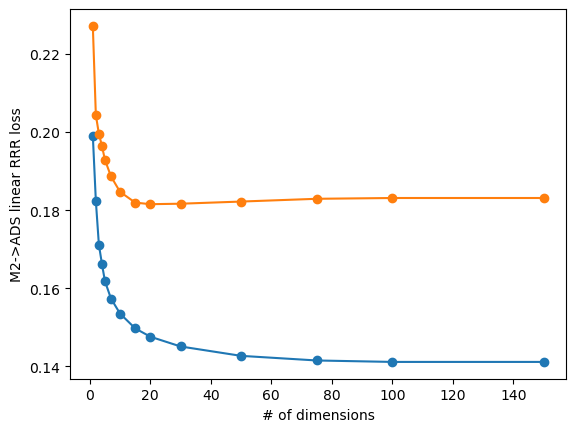

In [253]:
plt.plot(dims, acc, marker='o'); plt.xlabel("# of dimensions"); plt.ylabel("M2->ADS linear RRR loss");
plt.plot(dims, test_acc, marker='o');

In [249]:
dims = [1,2,3,4,5,7,10,15, 20, 30 , 50, 75, 100, 150]

Text(0, 0.5, 'Fraction of total variance explained')

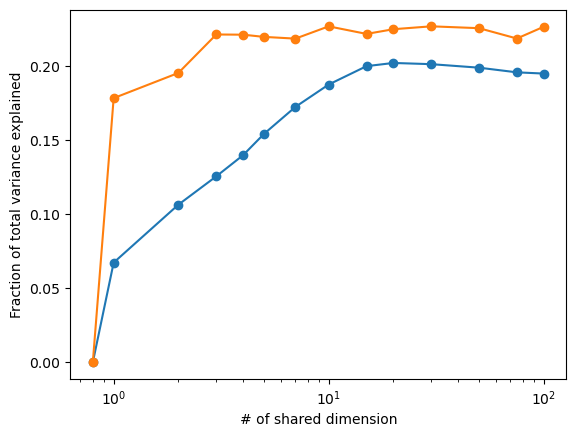

In [27]:
plt.plot(np.concatenate(([0.8], dims[:-1])), np.concatenate(([0],test_vars[:-1])), marker='o'); plt.xscale("log")
plt.plot(np.concatenate(([0.8], dims[:-1])), np.concatenate(([0],cross_test_vars[:-1])), marker='o');
# plt.plot(dims[:-2], splice_test_vars, marker='o')
plt.xlabel("# of shared dimension"); plt.ylabel("Fraction of total variance explained")

### SPLICE

In [22]:
class new_nl(nn.Module):
    def __init__(self, nInputs, nOutputs, nShared, nPrivSource, nPrivTarget, nHiddenLayers=10):
        super().__init__()
        # save params
        self.nInputs = nInputs
        self.nOutputs = nOutputs
        self.nShared = nShared
        self.nPrivSource = nPrivSource
        self.nPrivTarget = nPrivTarget

        # encoders
        self.source_enc = nl3ize(self.nInputs, self.nPrivSource, nHiddenLayers, 200); 
        self.shared_source_enc = nl3ize(self.nInputs, self.nShared, nHiddenLayers, 200); 
        self.shared_target_enc = nl3ize(self.nOutputs, self.nShared, nHiddenLayers, 200)
        self.target_enc = nl3ize(self.nOutputs, self.nPrivTarget, nHiddenLayers, 100)
        
        # measurement networks
        # self.msr_source = encoder(self.nPrivTarget, self.nShared, layers_msr)
        # self.msr_target = encoder(self.nPrivSource, self.nShared, layers_msr)
        self.msr_source = nl3ize(self.nPrivTarget, self.nInputs, nHiddenLayers, 200)
        self.msr_target = nl3ize(self.nPrivSource, self.nOutputs, nHiddenLayers, 200)
        
        # decoders
        self.source_dec = nl3ize(self.nPrivSource + self.nShared, self.nInputs, nHiddenLayers, 200) 
        self.target_dec = nl3ize(self.nPrivSource + self.nShared, self.nOutputs, nHiddenLayers, 200) 

    def forward(self, x, y):
        # calculate latents
        z_x = self.source_enc(x)
        z_s_x = self.shared_source_enc(x)
        z_s_y = self.shared_target_enc(y)
        z_y = self.target_enc(y)
        
        # estimate shared from private
        m_s_x = self.msr_source(z_y)
        m_s_y = self.msr_target(z_x)
        
        # calculate reconstructions
        x_hat = self.source_dec(torch.hstack((z_x, z_s_y)))
        y_hat = self.target_dec(torch.hstack((z_s_x, z_y)))

        return z_x, z_s_x, z_s_y, z_y, m_s_x, m_s_y, x_hat, y_hat

In [23]:
# nShared = 3
nInputs = HPC_train.shape[1]
nOutputs = PFC_train.shape[1]

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dims = [1,2,3,4,5,7,10,15, 20, 30 , 50, 75]
# dims=[3]
splice_accs = np.ones_like(dims, dtype="float")
splice_accs_test = np.ones_like(dims, dtype="float")
splice_test_vars = np.zeros_like(dims, dtype="float")
min_test = 999

# ------------ train SPLICE --------------
# instantiate model + training
for j, dim in enumerate(dims):
    print("---------------- DIM = %d ----------------" % dim)
    model = new_nl(nInputs, nOutputs, dim, 1, 1).to(device)

    lr = 0.001
    num_epochs = 1501
    msr_iter = 3
    c = np.linspace(1, 1, 25001)

    main_params = (list(model.source_enc.parameters()) + list(model.target_enc.parameters()) +
        list(model.source_dec.parameters()) + list(model.target_dec.parameters()))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = LinearLR(optimizer, total_iters = 25001, start_factor=1, end_factor=1/50)

    shared_params = (list(model.shared_source_enc.parameters())) + (list(model.shared_target_enc.parameters()))
    shared_optimizer = torch.optim.Adam(shared_params, lr=lr)
    shared_scheduler = LinearLR(shared_optimizer, total_iters = 25001, start_factor=1, end_factor=1/50)

    msr_params = list(model.msr_source.parameters()) + list(model.msr_target.parameters()) 
    msr_optimizer = torch.optim.Adam(msr_params, lr=lr)
    msr_scheduler = LinearLR(msr_optimizer, total_iters = 4000, start_factor=1, end_factor=1/50)

    msr_mean_loss = torch.Tensor([0])[0]

    # training loop
    # 1) minimize source/target reconstructions, difference between shared latents
        # a) unfreeze all weights
    for epoch in range(num_epochs):
        for param in model.parameters():
            param.requires_grad = True

        # slow shared encoding learning
        # if epoch == 1500:
        #     shared_optimizer = torch.optim.Adam(shared_params, lr=lr/1000)

        # cold restart measurement networks
        if epoch % 200 == 199:
            msr_iter = 1000
            model.msr_source = nl3ize(1,nInputs,10,200).to(device)
            model.msr_target = nl3ize(1,nOutputs,10,200).to(device)
            msr_params = list(model.msr_source.parameters()) + list(model.msr_target.parameters()) 
            msr_optimizer = torch.optim.Adam(msr_params, lr=0.001)
            msr_scheduler = LinearLR(msr_optimizer, total_iters = 4000, start_factor=1, end_factor=1/50)
        else:
            msr_iter = 3

        model.train()
            
        # b) calculate losses
        z_x, z_s_x, z_s_y, z_y, m_s_x, m_s_y, x_hat, y_hat = model(HPC_train, PFC_train)
        source_loss = torch.nn.functional.mse_loss(HPC_train, x_hat)
        target_loss = torch.nn.functional.mse_loss(PFC_train, y_hat)
        step1_loss = (source_loss + target_loss)
        
        # c) backpropagate
        optimizer.zero_grad()
        shared_optimizer.zero_grad()
        step1_loss.backward()
        optimizer.step()
        shared_optimizer.step()

        z_x, z_s_x, z_s_y, z_y, m_s_x, m_s_y, x_hat, y_hat = model(HPC_test, PFC_test)
        test_source_loss = torch.nn.functional.mse_loss(HPC_test, x_hat)
        test_target_loss = torch.nn.functional.mse_loss(PFC_test, y_hat)


    # 2) train measurement networks (msr_x, msr_y)
        # a) freeze other networks
        for param in model.parameters():
            param.requires_grad = False
        for param in model.msr_source.parameters():
            param.requires_grad = True
        for param in model.msr_target.parameters():
            param.requires_grad = True

        for i in range(msr_iter):
            # b) calculate loss
            z_x, z_s_x, z_s_y, z_y, m_s_x, m_s_y, x_hat, y_hat = model(HPC_train, PFC_train)  
            # msr_loss = nShared/2 * (torch.nn.functional.mse_loss(z_s_x, m_s_x)/z_s_x.detach().var(dim=0).sum() + 
            #                         torch.nn.functional.mse_loss(z_s_y, m_s_y)/z_s_y.detach().var(dim=0).sum())
            msr_loss = (nInputs/2 * torch.nn.functional.mse_loss(HPC_train, m_s_x)/HPC_train.detach().var(dim=0).sum() 
            + nOutputs/2 * torch.nn.functional.mse_loss(PFC_train, m_s_y)/PFC_train.detach().var(dim=0).sum())

            # c) backpropagate
            msr_optimizer.zero_grad()
            msr_loss.backward()
            msr_optimizer.step()

            msr_scheduler.step()

        z_x, z_s_x, z_s_y, z_y, m_s_x, m_s_y, x_hat, y_hat = model(HPC_test, PFC_test)  
        test_msr_loss = (nInputs/2 * torch.nn.functional.mse_loss(HPC_test, m_s_x)/HPC_test.detach().var(dim=0).sum() 
            + nOutputs/2 * torch.nn.functional.mse_loss(PFC_test, m_s_y)/PFC_test.detach().var(dim=0).sum())


        # if epoch > 600:
        # 3) train private encoders to minimize shared info
        # a) freeze other networks
        # for param in model.parameters():
        #     param.requires_grad = False
        # for param in model.source_enc.parameters():
        #     param.requires_grad = True
        # for param in model.target_enc.parameters():
        #     param.requires_grad = True


        # for i in range(1):
        # # b) calculate loss
        #     z_x, z_s_x, z_s_y, z_y, m_s_x, m_s_y, x_hat, y_hat = model(HPC_train, PFC_train) 

        #     # x_loss = m_s_x.var(dim=0).sum()/z_s_x.var(dim=0).sum()
        #     # y_loss = m_s_y.var(dim=0).sum()/z_s_y.var(dim=0).sum()

        #     x_loss = m_s_x.var(dim=0).sum()/HPC_train.var(dim=0).sum()
        #     y_loss = m_s_y.var(dim=0).sum()/PFC_train.var(dim=0).sum()

        #     msr_mean_loss = c[epoch]*(x_loss + y_loss)   

        #     #c) backpropagate
        #     optimizer.zero_grad()
        #     msr_mean_loss.backward()
        #     optimizer.step()

        # scheduler.step()
        # shared_scheduler.step()
        
        if epoch % 100 == 0:
            print("""EPOCH %d \t train source loss: %.4f \t train target loss: %.4f \t train msr_loss: %.4f \t msr_mean_loss: %.4f 
                \t test source loss: %.4f \t test target loss: %.4f \t test msr loss: %.4f \n"""
                % (epoch, 
                    source_loss.detach().cpu().numpy(), 
                    target_loss.detach().cpu().numpy(), 
                    (msr_loss).detach().cpu().numpy(), 
                    (msr_mean_loss/c[epoch]).detach().cpu().numpy(),
                    test_source_loss.detach().cpu().numpy(), 
                    test_target_loss.detach().cpu().numpy(), 
                    (test_msr_loss).detach().cpu().numpy(), 
                )
            )
    
        min_test = min(min_test, torch.nn.functional.mse_loss(model(HPC_test, PFC_test)[-1], PFC_test).detach().cpu().numpy())

        s1 = torch.var(PFC_test, dim=0).mean()
        s2 = torch.var(PFC_test - model(HPC_test, PFC_test)[-1], dim=0).mean()
        splice_test_vars[j] = max(splice_test_vars[j], 1-s2/s1)

    splice_accs[j] = loss.detach().cpu().numpy()
    splice_accs_test[j] = min_test
    


---------------- DIM = 1 ----------------
EPOCH 0 	 train source loss: 0.4351 	 train target loss: 0.2223 	 train msr_loss: 1.0034 	 msr_mean_loss: 0.0000 
                	 test source loss: 0.4132 	 test target loss: 0.2405 	 test msr loss: 1.0609 

EPOCH 100 	 train source loss: 0.2839 	 train target loss: 0.1604 	 train msr_loss: 0.9263 	 msr_mean_loss: 0.0000 
                	 test source loss: 0.2795 	 test target loss: 0.1850 	 test msr loss: 1.0359 

EPOCH 200 	 train source loss: 0.2559 	 train target loss: 0.1511 	 train msr_loss: 0.9097 	 msr_mean_loss: 0.0000 
                	 test source loss: 0.2777 	 test target loss: 0.1804 	 test msr loss: 1.0263 

EPOCH 300 	 train source loss: 0.2403 	 train target loss: 0.1416 	 train msr_loss: 0.9112 	 msr_mean_loss: 0.0000 
                	 test source loss: 0.2843 	 test target loss: 0.1764 	 test msr loss: 1.0204 

EPOCH 400 	 train source loss: 0.2325 	 train target loss: 0.1345 	 train msr_loss: 0.9031 	 msr_mean_loss: 0.00

KeyboardInterrupt: 

In [91]:
s1 = torch.var(PFC_test, dim=0).mean()
s2 = torch.var(PFC_test - model(HPC_test, PFC_test)[-1], dim=0).mean()
print(1-s2/s1)

tensor(0.2476, device='cuda:0')


In [98]:
z_x, z_s_x, z_s_y, z_y, m_s_x, m_s_y, x_hat, y_hat = model(HPC_train, PFC_train) # type: ignore
z_x_bar = z_x.mean(axis=0).detach()
z_y_bar = z_y.mean(axis=0).detach()

hpc_in = torch.hstack((torch.ones((z_x.shape[0], 1)).to(device)*z_x_bar[0], z_s_y.to(device))).to(device)
pfc_in = torch.hstack((z_s_x.to(device), torch.ones((z_y.shape[0], 1)).to(device)*z_y_bar[0])).to(device)

hpc_fix = model.source_dec(hpc_in).detach().cpu().numpy() # type: ignore
pfc_fix = model.target_dec(pfc_in).detach().cpu().numpy() # type: ignore

In [93]:
z_x, z_s_x, z_s_y, z_y, m_s_x, m_s_y, x_hat, y_hat = model(HPC_test, PFC_test) # type: ignore
z_x_bar = z_x.mean(axis=0).detach()
z_y_bar = z_y.mean(axis=0).detach()

hpc_in_test = torch.hstack((torch.ones((z_x.shape[0], 1)).to(device)*z_x_bar[0], z_s_y.to(device))).to(device)
pfc_in_test = torch.hstack((z_s_x.to(device), torch.ones((z_y.shape[0], 1)).to(device)*z_y_bar[0])).to(device)

hpc_fix_test = model.source_dec(hpc_in_test) # type: ignore
pfc_fix_test = model.target_dec(pfc_in_test) # type: ignore

In [135]:
# lgn dists
neigh = NearestNeighbors(n_neighbors=50, metric='euclidean').fit(hpc_fix)
neighbors = neigh.kneighbors(hpc_fix, return_distance=False)[:,1:]    # type: ignore
pair_dists = pairwise_distances(hpc_fix)
graph = np.zeros_like(pair_dists)
for i in range(pair_dists.shape[0]):
    graph[i, neighbors[i]] = pair_dists[i, neighbors[i]]
hpc_dists = dijkstra(graph, directed=False)
hpc_dists = torch.Tensor(hpc_dists)
hpc_dists[hpc_dists == np.inf] = hpc_dists[hpc_dists != np.inf].max()

# v1 dists
neigh = NearestNeighbors(n_neighbors=50, metric='euclidean').fit(pfc_fix)
neighbors = neigh.kneighbors(pfc_fix, return_distance=False)[:,1:]    # type: ignore
pair_dists = pairwise_distances(pfc_fix)
graph = np.zeros_like(pair_dists)
for i in range(pair_dists.shape[0]):
    graph[i, neighbors[i]] = pair_dists[i, neighbors[i]]
pfc_dists = dijkstra(graph, directed=False)
pfc_dists = torch.Tensor(pfc_dists)

In [137]:
pfc_dists.max()

tensor(34.1058)

In [138]:
dists = (hpc_dists + pfc_dists)
dists = torch.Tensor(dists).to(device)

pfc_dists = pfc_dists.to(device)

In [139]:
def iso_loss_func(target, out, z, dists):
    loss = torch.nn.functional.mse_loss(target, out, reduction='mean')

    prox = torch.linalg.norm(dists-torch.cdist(z,z))/(dists.shape[0]**2)
    return loss + 50*prox, loss, prox    # 50 seems to work well when norm of target frame is ~500x the norm of dists/# of pairs

In [333]:
np.save("./hpc_fix.npy", hpc_fix)
np.save("./pfc_fix.npy", pfc_fix)

np.save("./hpc_fix_test.npy", hpc_fix_test.detach().cpu().numpy())
np.save("./pfc_fix_test.npy", pfc_fix_test.detach().cpu().numpy())

np.save("./hpc_dists.npy", hpc_dists.detach().cpu().numpy())
np.save("./pfc_dists.npy", pfc_dists.detach().cpu().numpy())
np.save("./dists.npy", dists.detach().cpu().numpy())

np.save("./var_inds.npy", var_inds)

In [3]:
hpc_fix = np.load("./hpc_fix.npy")
pfc_fix = np.load("./pfc_fix.npy")

hpc_fix_test = torch.Tensor(np.load("./hpc_fix_test.npy")).to(device)
pfc_fix_test = torch.Tensor(np.load("./pfc_fix_test.npy")).to(device)

hpc_dists = torch.Tensor(np.load("./hpc_dists.npy")).to(device)
pfc_dists = torch.Tensor(np.load("./pfc_dists.npy")).to(device)
dists = torch.Tensor(np.load("./dists.npy")).to(device)

var_inds = np.load("./var_inds.npy")

In [155]:
# -------------------------- ISOMAP -------------------------------------
lr = 0.001
num_epochs = 25001
nShared = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
iso_ce = bottleneck(hpc_fix.shape[1], pfc_fix.shape[1], nShared, 10, 200).to(device)

inputs = torch.from_numpy(hpc_fix).to(device)
targets = torch.from_numpy(pfc_fix).to(device)
optimizer = torch.optim.Adam(iso_ce.parameters(), lr=lr)
scheduler = LinearLR(optimizer, total_iters = 25000, start_factor=1, end_factor=1/50)

best_rec = 9999

for epoch in range(num_epochs):
    print(epoch)
    
    out, z = iso_ce(inputs)
    loss, mse, prox = iso_loss_func(out, targets, z, hpc_dists.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch%100 == 0:
        print("Epoch %d | train loss: %.4f | train mse: %.4f | train prox: %.4f | test mse: %.4f" % 
             (epoch, 
             loss.detach().cpu().numpy(),
             mse.detach().cpu().numpy(), 
             prox.detach().cpu().numpy(),
             torch.nn.functional.mse_loss(pfc_fix_test, iso_ce(hpc_fix_test)[0]).detach().cpu().numpy()
             )
        )

0
Epoch 0 | train loss: 0.1002 | train mse: 0.0774 | train prox: 0.0005 | test mse: 0.0740
1
2
3
4
5
6


KeyboardInterrupt: 

In [13]:
pfc_fix.shape

(11903, 348)

In [149]:
s1 = torch.var(targets, dim=0).mean()
s2 = torch.var(targets - iso_ce(inputs)[0], dim=0).mean()
print(1-s2/s1)

tensor(0.7009, device='cuda:0', grad_fn=<RsubBackward1>)


In [150]:
z = z.detach().cpu().numpy()

In [151]:
df = pd.DataFrame(z)
df.insert(df.shape[1], 'pos', mat['variables']['position'][var_inds])

In [152]:
fig = px.scatter(df.loc[~np.isnan(df['pos'])], x=0, y=1, 
              color='pos',
              color_continuous_scale=px.colors.sequential.YlOrRd,
              )
fig.show(renderer='browser')

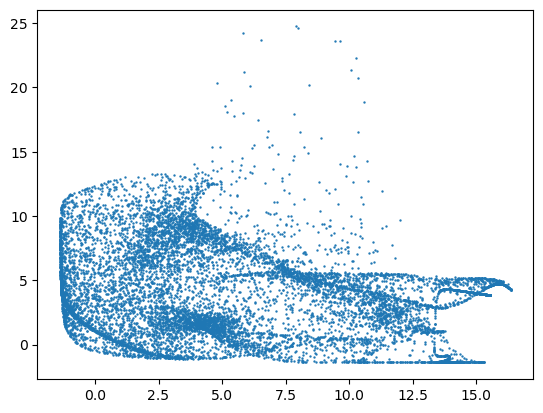

In [21]:
plt.scatter(z[:,0], z[:,1], s=.5)

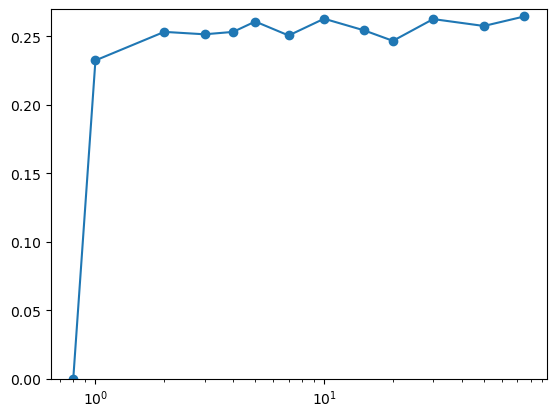

In [258]:
plt.plot(np.concatenate(([.8],dims[:-2])), np.concatenate(([0],splice_test_vars)), marker='o'); plt.ylim([0, .27]); plt.xscale("log")

In [271]:
splice_low = splice_test_vars[0] - cross_test_vars[0]
splice_high = splice_test_vars.max() - splice_low
splice_var_norm = (splice_test_vars - splice_low)/splice_high

In [272]:
rrr_high = test_vars.max()
rrr_var_norm = test_vars/rrr_high

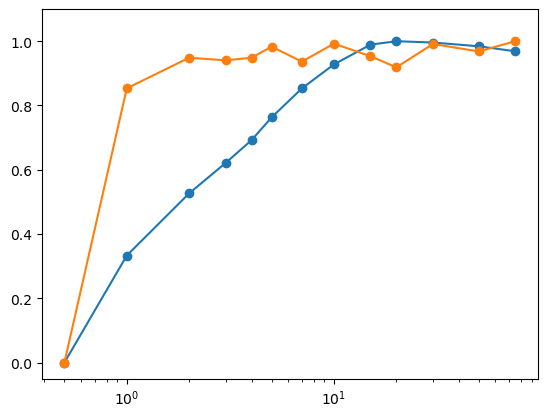

In [283]:
plt.plot(np.concatenate(([.5], dims[:-2])), np.concatenate(([0],rrr_var_norm[:-2])), marker='o');
plt.plot(np.concatenate(([.5], dims[:-2])), np.concatenate(([0],splice_var_norm)), marker='o'); plt.ylim(-.05, 1.1); plt.xscale("log")
plt.savefig("./hpc-pfc-dim.svg", transparent=True)

In [ ]:
splice_test_vars